In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
len(df)

42000

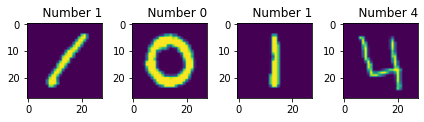

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=4)
for i in range(4):
    ax[i].set_title("    Number {}".format(df.loc[i][0]))
    ax[i].imshow(np.array(df.loc[i][1:]).reshape(28,28))
fig.tight_layout()
plt.show()